In [1]:
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
import h5py
import pickle
import requests
import os.path
from astropy.cosmology import LambdaCDM
from unyt import Myr, K
from synthesizer.particle import Stars, Galaxy
from synthesizer.grid import Grid
from synthesizer.emission_models import IncidentEmission, PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Greybody

In [2]:
api_key = "c37483fea84b70f4ad9f777c38357ea0"

### Get properties of the simulation

In [3]:
baseUrl = 'http://www.tng-project.org/api/TNG50-1/'
headers = {"api-key":api_key}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

simulation = get(baseUrl)

### Define cosmology

In [4]:
h = simulation['hubble']
Om0 = simulation['omega_0']
Ode0 = simulation['omega_L']
H0 = h * 100 
Ob0 = simulation['omega_B']

cosmo = LambdaCDM(Om0=Om0, Ode0=Ode0, H0=H0, Ob0=Ob0)

In [5]:
# create a dictionary of snapshots and redshifts (useful later)
snapshots = get(simulation['snapshots'])
snapshot_redshifts = {snapshot['number']: snapshot['redshift'] for snapshot in snapshots}


### Define choice of galaxy/redshift

In [6]:
id = '145492'
redshift = 2.0

### Download data

In [7]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open('data/'+filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r


# the quantities that we want to grab: the coordinates, metallicity, age, and initial mass of all the star particles
params = {'stars':'Coordinates,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass'}

# the data url for the object of interest
url = f"{baseUrl}/snapshots/z={str(redshift)}/subhalos/{str(id)}"

# Download the subhalo properties for the specific galaxy and save them as pickle file
subhalo_properties_filename = f'data/subhalo_properties_{id}.pck'
if not os.path.isfile(subhalo_properties_filename):
    subhalo_properties = get(url) # get json response of subhalo properties
    pickle.dump(subhalo_properties, open(subhalo_properties_filename,'wb'))

# Download the HDF5 cutout for the galaxy if it hasn't already been downloaded
cutout_filename = f'data/cutout_{id}.hdf5'
if not os.path.isfile(cutout_filename):
    get(url + "/cutout.hdf5", params) # get and save HDF5 cutout file

Print sub-halo properties and determine the exact snapshot redshift

In [8]:
subhalo_properties = pickle.load(open(f'data/subhalo_properties_{id}.pck','rb'))
for k,v in subhalo_properties.items():
    print(f'{k}: {v}')

snapshot_redshift = snapshot_redshifts[subhalo_properties['snap']]
print(f'snapshot redshift: {snapshot_redshift}')

snap: 33
id: 145492
bhmdot: 0.00214158
cm_x: 2631.63
cm_y: 22423.6
cm_z: 32813.0
gasmetallicity: 0.0234775
gasmetallicityhalfrad: 0.0332981
gasmetallicitymaxrad: 0.0139534
gasmetallicitysfr: 0.0156152
gasmetallicitysfrweighted: 0.0216725
pos_x: 2614.18
pos_y: 22429.6
pos_z: 32811.7
halfmassrad: 71.0307
halfmassrad_gas: 67.2129
halfmassrad_dm: 75.0715
halfmassrad_stars: 7.5072
halfmassrad_bhs: 0.0
len: 2303786
len_gas: 793943
len_dm: 1201183
len_stars: 308659
len_bhs: 1
mass: 43.4305
mass_gas: 5.0807
mass_dm: 36.9205
mass_stars: 1.42703
mass_bhs: 0.002327
massinhalfrad: 2.0413
massinhalfrad_gas: 0.196656
massinhalfrad_dm: 1.12881
massinhalfrad_stars: 0.713511
massinhalfrad_bhs: 0.002327
massinmaxrad: 12.493
massinmaxrad_gas: 1.64067
massinmaxrad_dm: 9.48976
massinmaxrad_stars: 1.36023
massinmaxrad_bhs: 0.002327
massinrad: 4.61426
massinrad_gas: 0.622574
massinrad_dm: 2.90797
massinrad_stars: 1.08139
massinrad_bhs: 0.002327
sfr: 15.455
sfrinhalfrad: 4.07666
sfrinmaxrad: 15.043
sfrinrad: 

### Creating a Galaxy object

After downloading the data we need to create a synthesizer galaxy object.


In [9]:

with h5py.File(cutout_filename) as f:

    # GFM_StellarFormationTime is the scale factor when the  
    formation_scale_factor = f['PartType4']['GFM_StellarFormationTime'][()]
    formation_redshift = 1/formation_scale_factor - 1.0
    
    # only select star particles that make sense
    s = formation_redshift >= snapshot_redshift
    formation_redshift = formation_redshift[s]

    # calculate the ages of star particle and record as unyt quantity
    ages = (cosmo.age(z=snapshot_redshift)-cosmo.age(formation_redshift)).to('Myr').value * Myr

    # convert units of initial masses
    initial_masses = f['PartType4']['GFM_InitialMass'][s] * 1E10 / h

    # define the coorindates of the galaxy 
    x = f['PartType4']['Coordinates'][s,0] 
    y = f['PartType4']['Coordinates'][s,1] 
    z = f['PartType4']['Coordinates'][s,2] 

    # convert coordinates to physical and change the units
    coordinates = np.array([x,y,z]).T / (1+snapshot_redshift) / h / 1000

    # create a stars object
    stars = Stars(
        ages=ages,
        initial_masses=initial_masses,
        metallicities=f['PartType4']['GFM_Metallicity'][s],
        coordinates=coordinates,
        )


centre = np.array([subhalo_properties['pos_x'],
                   subhalo_properties['pos_y'],
                   subhalo_properties['pos_z'],
                   ])

# initialise the galaxy object
galaxy = Galaxy(stars=stars, centre=centre)

/Users/sw376/Dropbox/Research/projects/synth_sed/venv/lib/python3.10/site-packages/synthesizer/particle/galaxy.py:256: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()
/Users/sw376/Dropbox/Research/projects/synth_sed/venv/lib/python3.10/site-packages/synthesizer/particle/galaxy.py:110: RuntimeWarning: In `load_gas`: one of either `masses` or `metallicities` is not provided, setting `gas` object to `None`
  self.load_gas(gas=gas)
/Users/sw376/Dropbox/Research/projects/synth_sed/venv/lib/python3.10/site-packages/synthesizer/particle/galaxy.py:117: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()


### Initialise a SPS grid

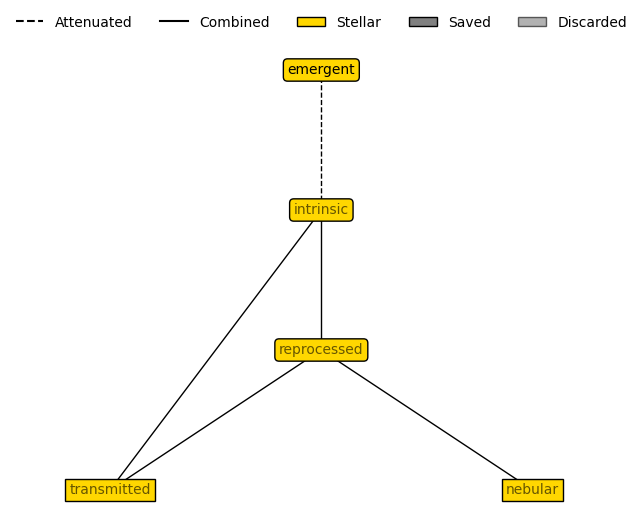

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [36]:

galaxy.stars.spectra = {}
galaxy.stars.particle_spectra = {}

# dust optical depth
tau_v = 0.1

# specify a power-law dust curve
alpha = -1.0 # dust curve slope
dust_curve = PowerLaw(slope=alpha)

# specify a 30K greybody for the dust emission
dust_emission_model = Greybody(30 * K, 1.2)

grid_dir = '../grids'
grid_name = 'test_grid'
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(2, 5, 600))

screen = PacmanEmission(grid=grid, tau_v=tau_v, dust_curve=dust_curve)
screen.set_save(False, set_all=True)
screen["emergent"].set_save(True)
screen.plot_emission_tree()



### Images

Create rest-frame images. 

In [37]:
from synthesizer.filters import UVJ, FilterCollection

galaxy.stars.get_particle_spectra(screen)

tophat_dict = {
    "B": {"lam_min": 1400, "lam_max": 1600},
    "G": {"lam_min": 3000, "lam_max": 5000},
    "R": {"lam_min": 5000, "lam_max": 7000},
}

filters = FilterCollection(tophat_dict=tophat_dict, new_lam=grid.lam)

# galaxy.stars.get_particle_photo_luminosities(filters)




In [38]:
galaxy.stars.get_particle_photo_luminosities(filters)

{'attenuated': <synthesizer.photometry.PhotometryCollection at 0x106b33a30>,
 'total': <synthesizer.photometry.PhotometryCollection at 0x3ae60b5e0>,
 'emergent': <synthesizer.photometry.PhotometryCollection at 0x474bdb820>}

1.1959765964854834e+30


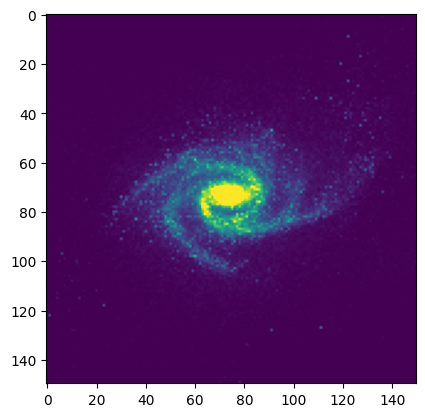

In [40]:
from unyt import kpc

fov = 40 * kpc
npix = 150
resolution = fov / npix

img = galaxy.get_images_luminosity(
    resolution=resolution,
    stellar_photometry="emergent",
    fov=fov,
)

print(np.sum(img.imgs['R'].arr))
# plt.imshow(np.log10(img.imgs['R'].arr))
plt.imshow(img.imgs['R'].arr, vmin = 0.0, vmax = 1E27)
plt.show()

# img.imgs['R'].arr /= (0.6)
# img.imgs['G'].arr /= (0.5)
# img.imgs['B'].arr /= (0.15)

img.imgs['R'].arr /= (0.5)
img.imgs['G'].arr /= (0.4)
img.imgs['B'].arr /= (0.15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8.141722791939452].


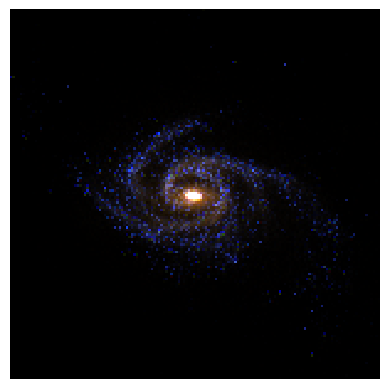

In [41]:
# Make and plot an rgb image
img.make_rgb_image(
    # rgb_filters={"R": "J", "G": "V", "B": "U"},
    rgb_filters={"R": "R", "G": "G", "B": "B"},
)
fig, ax, _ = img.plot_rgb_image(show=True, vmin=0., vmax=5E27)

fig.set_size_inches(1,1, forward=True)
ax.axis('off')
# fig.savefig('rgb.png', dpi=100, bbox_inches='tight', pad_inches=0)